# Определение возраста покупателей

### Задача

---

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека.

### Данные

---

Датасет [ChaLearn Looking at People](https://chalearnlap.cvc.uab.cat/dataset/26/description/) - набор фотографий людей с указанием возраста.

### План проекта:

---

1. Исследовательский анализ данных.
    - Знакомство с данными. Анализ распределения таргета. Примеры фотографий.
2. Обучение модели.
3. Вывод.


## Исследовательский анализ данных

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Чтение данных

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [4]:
labels['file_name'].nunique()

7591

Выборка содержит 7591 размеченных фотографий людей возрастом от 1 до 100 лет. Пропусков и явных дубликатов нет.

### Распределение возраста

Посмотрим на график распределения возраста в выборке.

<AxesSubplot:xlabel='real_age', ylabel='Density'>

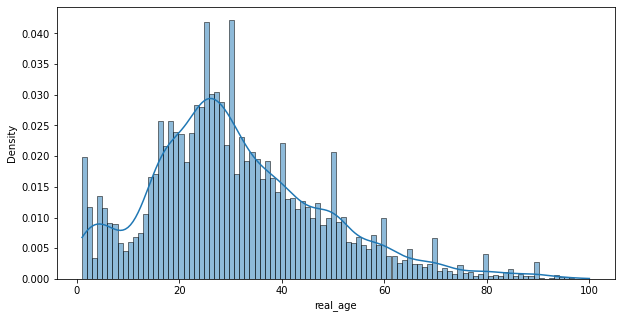

In [8]:
plt.figure(figsize=(10, 5))
sns.histplot(
    data=labels['real_age'],
    bins=100,
    kde=True,
    stat='density')

Распределение возраста в выборке асимметрично: данные скошены вправо, и имеется небольшой пик в начале распределения. Больше всего фотографий приходится на молодых людей в возрасте 20-35 лет. Есть пики возле круглых возрастов (30, 40, 50 и т.д.), вероятно, разметчики данных часто округляли возраст до ближайших юбилейных. Фотографий глубоко пожилых людей мало.

Скорее всего, с таким датасетом модель будет легко определять молодых людей 20, 25, 30 лет, но возникнут трудности с пожилыми людьми старше 80 лет.

### Примеры фото из датасета

Выведем на экран 12 случайных фотографий.

In [9]:
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
    labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345)

Found 7591 validated image filenames.


In [11]:
features, target = next(datagen_flow)

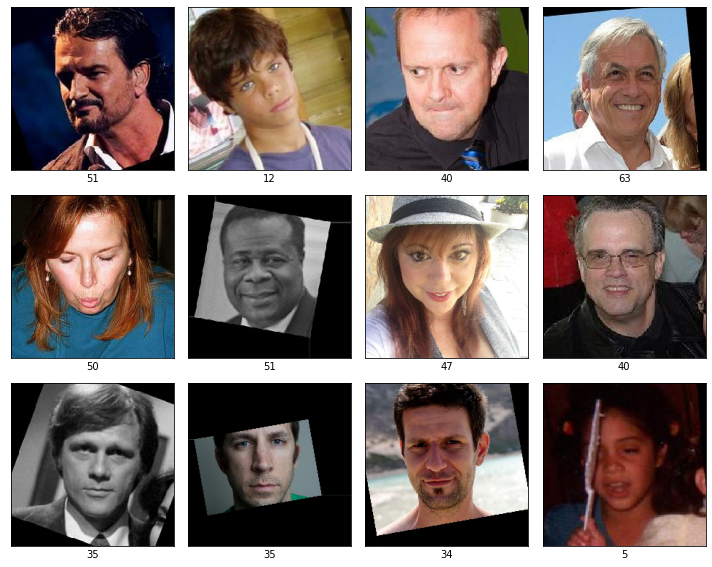

In [12]:
fig = plt.figure(figsize=(10,8))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(target[i])
    plt.tight_layout()

На первый взгляд разметка фотографий выполнена верно. Некоторые фотографии в датасете обрезаны и повернуты так, чтобы лицо находилось в центре изображения. Согласно [описанию](https://chalearnlap.cvc.uab.cat/dataset/26/description/) датасета фотографии подвергались процедуре детектирования лиц [Mathias et. al](http://markusmathias.bitbucket.org/2014_eccv_face_detection/). Среди фотографий есть и черно-белые.

**Промежуточный вывод:**

Датасет содержит 7591 фотографию в папке `/final_files` и разметку данных в csv-файле `labels.csv` с двумя колонками: `file_name` и `real_age`. Пропусков и явных дубликатов нет.

Можно выделить следующие особенности данных:
- представлены фотографии людей возрастом от 1 до 100 лет;
- больше всего фотографий приходится на людей в возрасте 20-35 лет;
- фотографий людей старше 80 мало;
- начиная с 25 лет, внутри каждой декады больше фотографий приходится на круглый возраст;
- на первый взгляд разметка фотографий выполнена верно;
- лица на фотографиях отцентрированы.

Так как в некоторых возрастных категориях данных довольно мало, есть смысл сделать аугментации изображений. Также можно было бы обогатить данные за счет дополнительных фотографий.

## Обучение модели

В качестве основы для модели возьмем ResNet50, предобученный на датасете ImageNet, без последних 2 слоев. Для нашей задачи сконструируем верхушку заново. Добавим GlobalAveragePooling2D и полносвязный слой с одним нейроном для предсказания непосредственно возраста. Функцию активации возьмем ReLU, так как возраст меньше 0 быть не может.

Так как изображений в датасете довольно много, будем использовать динамический загрузчик данных ImageDataGenerator.

Обучение модели происходит в специальном GPU-тренажере от Яндекса, который использует вычислительные ресурсы на сервере  [Yandex Compute Cloud](https://cloud.yandex.ru/services/compute). Для обучения в тренажере нужно написать несколько функций: функции загрузки обучающей и тестовой выборок (`load_train`, `load_test`), функцию создания модели (`create_model`), функцию обучения модели (`train_model`).

В итоге, в тренажер подается следующий код:

```python

import pandas as pd

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator



def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale=1./255,
                                       horizontal_flip=True,
                                       vertical_flip=True)
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    validation_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    
    validation_datagen_flow = validation_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return validation_datagen_flow

def create_model(input_shape):
    
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    optimizer = Adam(lr=0.0001)
    
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=15,
               steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch=len(train_data)
    if validation_steps is None:
        validation_steps=len(test_data)
    
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

Тренажер выводит промежуточные значения функции потерь и метрик в процессе обучения:

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps
Epoch 1/15
178/178 - 50s - loss: 256.7150 - mae: 11.6695 - val_loss: 677.7375 - val_mae: 21.0708
Epoch 2/15
178/178 - 40s - loss: 104.7965 - mae: 7.7159 - val_loss: 690.4844 - val_mae: 21.2540
Epoch 3/15
178/178 - 41s - loss: 80.2104 - mae: 6.7786 - val_loss: 242.0778 - val_mae: 11.3906
Epoch 4/15
178/178 - 40s - loss: 65.9089 - mae: 6.1970 - val_loss: 209.2669 - val_mae: 10.8809
Epoch 5/15
178/178 - 40s - loss: 52.6157 - mae: 5.5005 - val_loss: 94.2264 - val_mae: 7.3159
Epoch 6/15
178/178 - 44s - loss: 44.0513 - mae: 5.0441 - val_loss: 88.0625 - val_mae: 7.0908
Epoch 7/15
178/178 - 61s - loss: 39.6305 - mae: 4.8096 - val_loss: 75.7016 - val_mae: 6.5192
Epoch 8/15
178/178 - 64s - loss: 32.6703 - mae: 4.3830 - val_loss: 72.4391 - val_mae: 6.3177
Epoch 9/15
178/178 - 46s - loss: 29.8485 - mae: 4.1632 - val_loss: 75.8721 - val_mae: 6.6135
Epoch 10/15
178/178 - 58s - loss: 24.9020 - mae: 3.8618 - val_loss: 80.8832 - val_mae: 6.7447
Epoch 11/15
178/178 - 53s - loss: 23.6971 - mae: 3.7055 - val_loss: 68.3113 - val_mae: 6.2826
Epoch 12/15
Epoch 13/15
178/178 - 41s - loss: 21.9462 - mae: 3.5930 - val_loss: 80.0621 - val_mae: 6.6466
178/178 - 51s - loss: 20.2951 - mae: 3.4383 - val_loss: 85.8583 - val_mae: 6.9739
Epoch 14/15
178/178 - 47s - loss: 17.9691 - mae: 3.2426 - val_loss: 72.9857 - val_mae: 6.5108
Epoch 15/15
178/178 - 50s - loss: 16.5798 - mae: 3.0959 - val_loss: 67.2466 - val_mae: 6.0963

60/60 - 11s - loss: 67.2466 - mae: 6.0963
Test MAE: 6.0963

```

В результате обучения на 15 эпохах нам удалось достичь необходимого качества модели: MAE на тесте составила 6.0963, что лучше требуемого 8. Однако, на всех эпохах видно, что модель сильно переобучается. Это характерно для нейронных сетей с большим числом слоев.

## Вывод

Перед нами стояла задача построить модель, которая по фотографии определит приблизительный возраст человека, чтобы выполнять задачи:
- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.

В нашем распоряжении был датасет, состоящий из 7591 фотографии людей возрастом от 1 до 100 лет. В результате исследовательского анализа мы обнаружили, что:

- больше всего фотографий приходится на людей в возрасте 20-35 лет, а фотографий людей старше 80 мало, поэтому было решено использовать аугментации;
- начиная с 25 лет, внутри каждой декады больше фотографий приходится на круглый возраст;
- на первый взгляд разметка фотографий выполнена верно, и лица на фотографиях отцентрированы.

В основу модели лег ResNet50, где последний слой заменен на слой с одним нейроном и активацией ReLU для задачи регрессии. Так как ResNet50 - это нейронка с большим числом слоев, то наша модель получилась переобученной.

В результате обучения на 15 эпохах удалось достичь требуемого качества: MAE = 6.0963. Это значит, что в среднем модель может определить возраст человека на фотографии с ошибкой ± 6.1 лет. Такая модель довольно хорошо справится с первой задачей, так как границы возрастной группы, вероятно, будут намного больше этой ошибки. А вот со второй задачей модель вряд ли справится, ведь она может одобрить продажу алкоголя и 12-летнему подростку. 